In [28]:
# Celda 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# Estilo general de gráficos
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["figure.dpi"] = 130

# Ruta local al CSV (cambiar si hace falta)
FILE_PATH = r"C:\Users\gasto\Desktop\Taller de Programación\TP FINAL\MPFT FMI.csv"

OUT_DIR = Path(".")  # carpeta de salidas
OUT_DIR.mkdir(exist_ok=True)

In [29]:
# Celda 2
df = pd.read_csv(FILE_PATH, low_memory=False)

# Columnas prolijas
df.columns = df.columns.str.strip()

# Strings prolijos
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip().replace({"None": pd.NA, "nan": pd.NA})

print("Shape original:", df.shape)
display(df.head(3))
print(df.columns.tolist())

Shape original: (14176, 40)


,COUNTRY,INDICATOR,TYPE_OF_TRANSFORMATION,FREQUENCY,TIME_PERIOD,OBS_VALUE,SCALE,PRECISION,DECIMALS_DISPLAYED,TRANSFORMATION,...,ACCESS_SHARING_LEVEL,ACCESS_SHARING_NOTES,SECURITY_CLASSIFICATION,SOURCE,SHORT_SOURCE_CITATION,FULL_SOURCE_CITATION,LICENSE,SUGGESTED_CITATION,KEY_INDICATOR,SERIES_NAME
0,Kenya,Monetary Policy Report (C),Index,Annual,2007,100.0,Units,NaN,NaN,<NA>,...,Public (Unrestricted),NaN,Public or Unrestricted,Central Bank of Kenya,NaN,NaN,© International Monetary Fund Copyright. All R...,International Monetary Fund. Monetary Policy F...,NaN,NaN
1,Kenya,Monetary Policy Report (C),Index,Annual,2008,100.0,Units,NaN,NaN,<NA>,...,Public (Unrestricted),NaN,Public or Unrestricted,Central Bank of Kenya,NaN,NaN,© International Monetary Fund Copyright. All R...,International Monetary Fund. Monetary Policy F...,NaN,NaN
2,Kenya,Monetary Policy Report (C),Index,Annual,2009,100.0,Units,NaN,NaN,<NA>,...,Public (Unrestricted),NaN,Public or Unrestricted,Central Bank of Kenya,NaN,NaN,© International Monetary Fund Copyright. All R...,International Monetary Fund. Monetary Policy F...,NaN,NaN


['COUNTRY', 'INDICATOR', 'TYPE_OF_TRANSFORMATION', 'FREQUENCY', 'TIME_PERIOD', 'OBS_VALUE', 'SCALE', 'PRECISION', 'DECIMALS_DISPLAYED', 'TRANSFORMATION', 'UNIT', 'DERIVATION_TYPE', 'OVERLAP', 'IMF_REGION', 'INCOME_GROUP', 'DOI', 'FULL_DESCRIPTION', 'AUTHOR', 'PUBLISHER', 'DEPARTMENT', 'CONTACT_POINT', 'TOPIC', 'TOPIC_DATASET', 'KEYWORDS', 'KEYWORDS_DATASET', 'LANGUAGE', 'PUBLICATION_DATE', 'UPDATE_DATE', 'METHODOLOGY', 'METHODOLOGY_NOTES', 'ACCESS_SHARING_LEVEL', 'ACCESS_SHARING_NOTES', 'SECURITY_CLASSIFICATION', 'SOURCE', 'SHORT_SOURCE_CITATION', 'FULL_SOURCE_CITATION', 'LICENSE', 'SUGGESTED_CITATION', 'KEY_INDICATOR', 'SERIES_NAME']


In [30]:
# Celda 3
cols_keep = [
    "COUNTRY","INDICATOR","TIME_PERIOD","OBS_VALUE","INCOME_GROUP",
    "TYPE_OF_TRANSFORMATION","FREQUENCY","TRANSFORMATION","UNIT","SCALE"
]
df = df[cols_keep].copy()

# Renombres
df = df.rename(columns={"TIME_PERIOD":"YEAR","OBS_VALUE":"VALUE"})

# Tipos
df["YEAR"]  = pd.to_numeric(df["YEAR"], errors="coerce").astype("Int64")
df["VALUE"] = pd.to_numeric(df["VALUE"], errors="coerce")

# Filas válidas
df = df.dropna(subset=["COUNTRY","INDICATOR","YEAR","VALUE"]).copy()

print("Años:", int(df["YEAR"].min()), "→", int(df["YEAR"].max()))
print("Países:", df["COUNTRY"].nunique(), " | Indicadores:", df["INDICATOR"].nunique())
print("Shape post-limpieza:", df.shape)

Años: 2007 → 2018
Países: 53  | Indicadores: 19
Shape post-limpieza: (14176, 10)


In [31]:
# Celda 4
adv_mask = df["INCOME_GROUP"].str.contains("Advanced", case=False, na=False)
df_adv = df[adv_mask].copy()

# Excluir agregados/regiones (coincidencia exacta, sin regex ambiguo)
excluir_exact = [
    "Euro Area (EA)", "Euro Area", "European Union", "European Union (EU)",
    "World", "All", "Advanced Economies", "Emerging Market Economies",
    "Low-Income Developing Countries"
]
pat = "|".join(map(re.escape, excluir_exact))
df_adv = df_adv[~df_adv["COUNTRY"].str.contains(pat, case=False, na=False)]

print("Países avanzados detectados:", sorted(df_adv["COUNTRY"].unique()))
print("Shape avanzados:", df_adv.shape)

Países avanzados detectados: ['Australia', 'Canada', 'Czech Republic', 'Iceland', 'Israel', 'Japan', 'Korea, Republic of', 'New Zealand', 'Norway', 'Sweden', 'United Kingdom', 'United States']
Shape avanzados: (3648, 10)


In [32]:
# Celda 5
mask_canon = (
    (df_adv["FREQUENCY"].str.lower() == "annual") &
    (df_adv["UNIT"].str.lower() == "index") &
    (df_adv["SCALE"].str.lower() == "units") &
    (df_adv["TYPE_OF_TRANSFORMATION"].str.contains("^index$", case=False, na=False)) &
    (~df_adv["TRANSFORMATION"].str.contains("percent change", case=False, na=False))
)
df_can = df_adv[mask_canon].copy()

# Unicidad COUNTRY-YEAR-INDICATOR (colapso por mediana si hiciera falta)
g = df_can.groupby(["COUNTRY","YEAR","INDICATOR"]).size().reset_index(name="n")
dups = g[g["n"] > 1]
if not dups.empty:
    print(f"⚠️ Duplicados detectados: {len(dups)} — se colapsan con mediana.")
    df_can = (df_can.groupby(["COUNTRY","YEAR","INDICATOR"], as_index=False)["VALUE"].median())
else:
    df_can = df_can[["COUNTRY","YEAR","INDICATOR","VALUE"]].copy()

print("Shape final canónico:", df_can.shape)
display(df_can.head(8))

Shape final canónico: (2508, 4)


,COUNTRY,YEAR,INDICATOR,VALUE
180,Canada,2007,Announcing and Explaining the Policy Stance (C),100.000000
181,Canada,2008,Announcing and Explaining the Policy Stance (C),100.000000
182,Canada,2009,Announcing and Explaining the Policy Stance (C),100.000000
183,Canada,2010,Announcing and Explaining the Policy Stance (C),92.004441
184,Canada,2011,Announcing and Explaining the Policy Stance (C),92.004441
185,Canada,2012,Announcing and Explaining the Policy Stance (C),92.004441
186,Canada,2013,Announcing and Explaining the Policy Stance (C),100.000000
187,Canada,2014,Announcing and Explaining the Policy Stance (C),100.000000


In [33]:
# Celda 6
def pillar_of(ind_name: str) -> str:
    s = str(ind_name)
    if "(C)" in s: return "C"
    if "(PO)" in s or "(P0)" in s: return "PO"  # a veces aparece 0 por O
    if "(IA)" in s: return "IA"
    return "UNK"

panel = df_can.pivot_table(
    index=["COUNTRY","YEAR"],
    columns="INDICATOR",
    values="VALUE",
    aggfunc="first"
).reset_index()

ind_cols = [c for c in panel.columns if c not in ["COUNTRY","YEAR"]]
pmap = {c: pillar_of(c) for c in ind_cols}

panel["C_index"]  = panel[[c for c in ind_cols if pmap[c]=="C"]].mean(axis=1)
panel["PO_index"] = panel[[c for c in ind_cols if pmap[c]=="PO"]].mean(axis=1)
panel["IA_index"] = panel[[c for c in ind_cols if pmap[c]=="IA"]].mean(axis=1)
panel["Overall_index"] = panel[["C_index","PO_index","IA_index"]].mean(axis=1)

# Chequeos
print("Años:", panel["YEAR"].min(), "→", panel["YEAR"].max())
print("Países por año:\n", panel.groupby("YEAR")["COUNTRY"].nunique())
display(panel.head(10))

Años: 2007 → 2018
Países por año:
 YEAR
2007    11
2008    11
2009    11
2010    11
2011    11
2012    11
2013    11
2014    11
2015    11
2016    11
2017    11
2018    11
Name: COUNTRY, dtype: int64


INDICATOR,COUNTRY,YEAR,Announcing and Explaining the Policy Stance (C),Communication Cycle (C),Communications (C),Delegation and Designation of Responsibility (IA),Financial Arrangements (IA),Independence and Accountability (IA),"Independence and Accountability, Policy and Operational Strategy, Communication",Integrity of the Monetary Policymaking Body (IA),...,Policy Implementation (PO),Policy and Operational Strategy (P0),Publication of Data (C),Reporting and Oversight (IA),Stakeholder Inclusion (C),Tools (PO),C_index,PO_index,IA_index,Overall_index
0,Canada,2007,100.000000,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.000000,100.000000
1,Canada,2008,100.000000,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.000000,100.000000
2,Canada,2009,100.000000,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.000000,100.000000
3,Canada,2010,92.004441,100.0,101.309464,100.0,100.0,100.000000,100.462694,100.000000,...,100.000000,100.000000,100.000000,100.0,100.000000,100.0,101.229450,100.000000,100.000000,100.409817
4,Canada,2011,92.004441,100.0,101.309464,100.0,100.0,100.000000,100.462694,100.000000,...,100.000000,100.000000,100.000000,100.0,100.000000,100.0,101.229450,100.000000,100.000000,100.409817
5,Canada,2012,92.004441,100.0,101.309464,100.0,100.0,100.000000,100.462694,100.000000,...,100.000000,100.000000,100.000000,100.0,100.000000,100.0,101.229450,100.000000,100.000000,100.409817
6,Canada,2013,100.000000,100.0,107.032645,100.0,100.0,98.961251,102.280907,97.894815,...,100.000000,100.000000,116.631144,100.0,100.000000,100.0,105.794014,100.000000,99.476011,101.756675
7,Canada,2014,100.000000,100.0,107.032645,100.0,100.0,98.961251,102.280907,97.894815,...,100.000000,100.000000,116.631144,100.0,100.000000,100.0,105.794014,100.000000,99.476011,101.756675
8,Canada,2015,100.000000,100.0,107.032645,100.0,100.0,98.961251,102.280907,97.894815,...,100.000000,100.000000,116.631144,100.0,100.000000,100.0,105.794014,100.000000,99.476011,101.756675
9,Canada,2016,100.000000,100.0,103.708621,100.0,100.0,107.098121,103.503972,97.894815,...,108.690405,101.775148,136.028238,100.0,128.402542,100.0,105.629159,101.744259,103.854830,103.742749


In [35]:
# Celda 7 — EXPORTS SIMPLIFICADOS (solo CSV)

from pathlib import Path
out_dir = Path(".")  # carpeta actual

# 1) Panel final en formato ancho
panel.sort_values(["COUNTRY", "YEAR"]).to_csv(out_dir / "mpft_panel_advanced.csv", index=False)

# 2) Base larga (tidy)
df_can.to_csv(out_dir / "mpft_tidy_advanced.csv", index=False)

# 3) Matrices país×indicador (promedio y último año disponible)
matrix_mean = (
    df_can.pivot_table(index="COUNTRY", columns="INDICATOR", values="VALUE", aggfunc="mean")
    .round(2)
)
matrix_last = (
    df_can.sort_values("YEAR")
          .groupby(["COUNTRY", "INDICATOR"])
          .tail(1)
          .pivot(index="COUNTRY", columns="INDICATOR", values="VALUE")
          .round(2)
)

matrix_mean.to_csv(out_dir / "mpft_matrix_country_indicator_mean.csv")
matrix_last.to_csv(out_dir / "mpft_matrix_country_indicator_lastyear.csv")

# 4) Resumen por pilares (promedio 2007–2018 por país)
summary = (
    panel.groupby("COUNTRY")[["C_index", "PO_index", "IA_index", "Overall_index"]]
         .mean()
         .round(2)
         .sort_values("Overall_index", ascending=False)
)
summary.to_csv(out_dir / "mpft_summary_country_pillars.csv")

print("Exportados:")
for f in [
    "mpft_panel_advanced.csv",
    "mpft_tidy_advanced.csv",
    "mpft_matrix_country_indicator_mean.csv",
    "mpft_matrix_country_indicator_lastyear.csv",
    "mpft_summary_country_pillars.csv",
]:
    print(" -", f)

Exportados:
 - mpft_panel_advanced.csv
 - mpft_tidy_advanced.csv
 - mpft_matrix_country_indicator_mean.csv
 - mpft_matrix_country_indicator_lastyear.csv
 - mpft_summary_country_pillars.csv


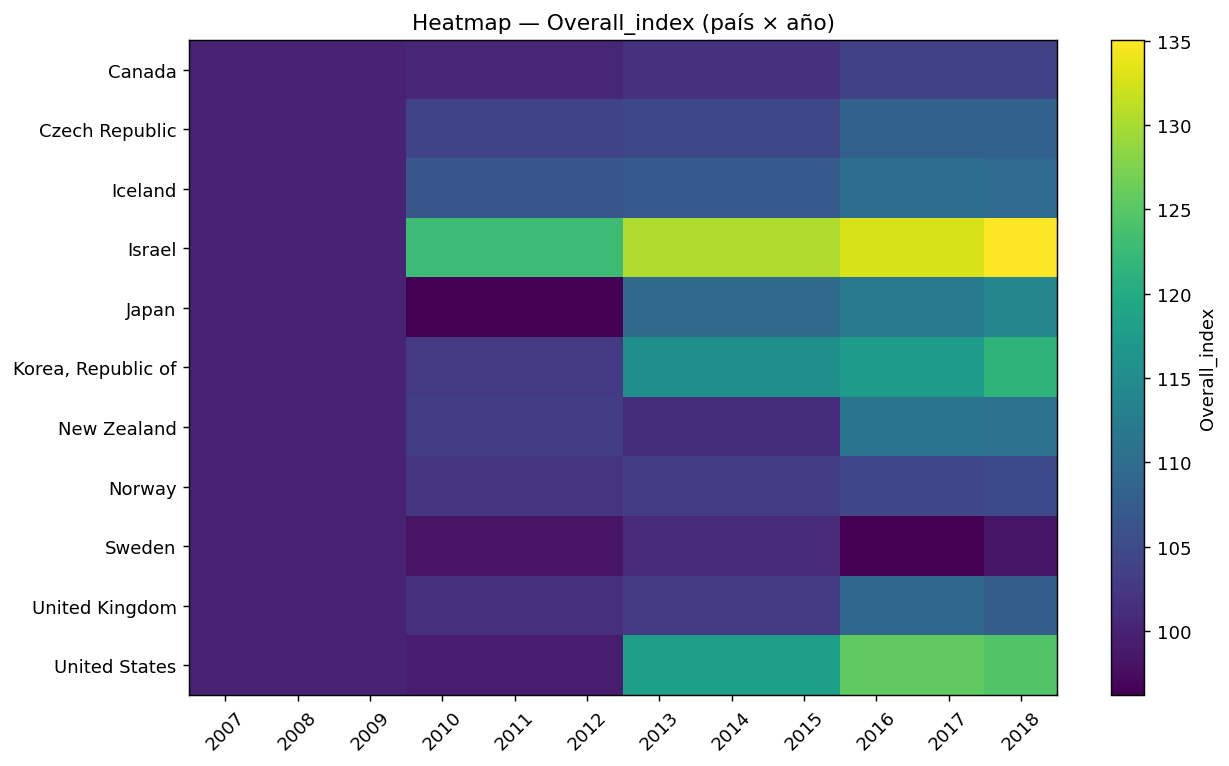

In [36]:
# Celda 8
pivot_heat = panel.pivot(index="COUNTRY", columns="YEAR", values="Overall_index").sort_index()
plt.figure(figsize=(10, 6))
im = plt.imshow(pivot_heat.values, aspect="auto")
plt.yticks(range(len(pivot_heat.index)), pivot_heat.index)
plt.xticks(range(len(pivot_heat.columns)), pivot_heat.columns, rotation=45)
plt.colorbar(im, label="Overall_index")
plt.title("Heatmap — Overall_index (país × año)")
plt.tight_layout()
plt.show()

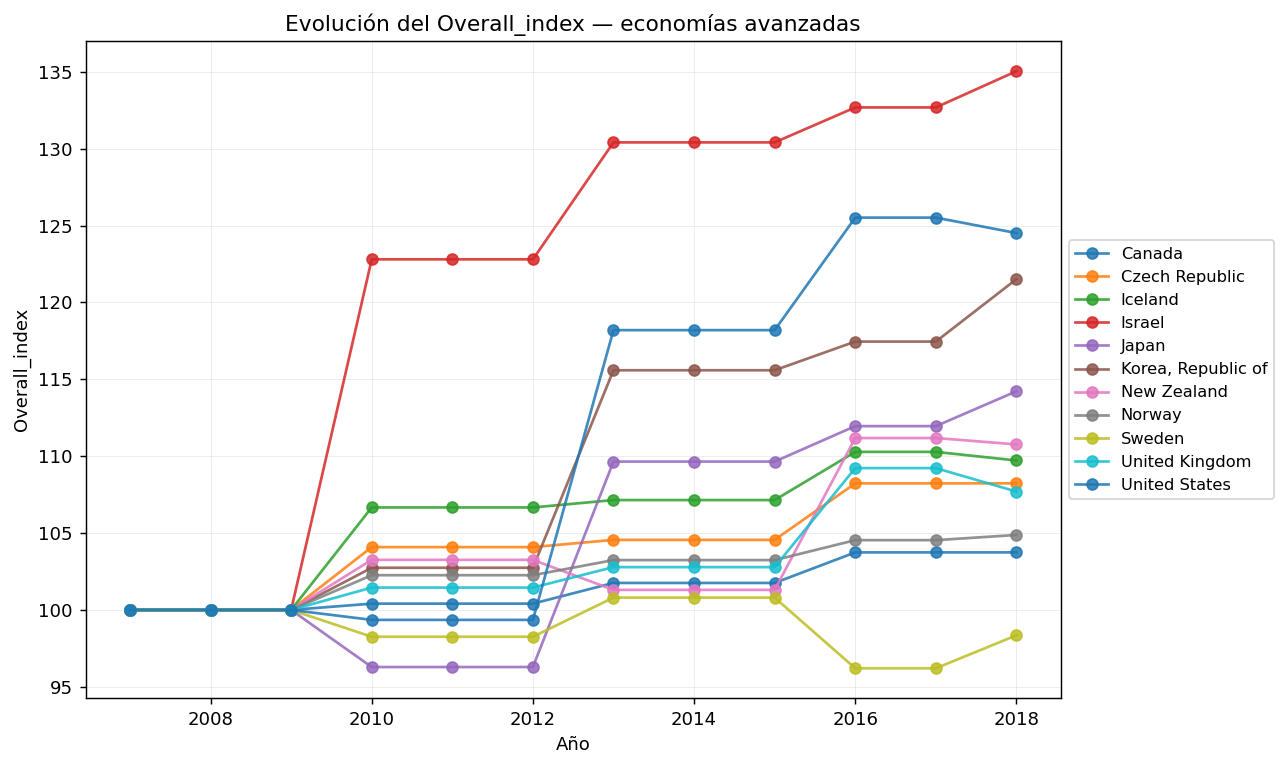

In [37]:
# Celda 9
plt.figure(figsize=(10, 6))
for pais, g in panel.sort_values("YEAR").groupby("COUNTRY"):
    plt.plot(g["YEAR"], g["Overall_index"], marker="o", alpha=0.85, label=pais)
plt.title("Evolución del Overall_index — economías avanzadas")
plt.xlabel("Año"); plt.ylabel("Overall_index")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1, fontsize=9)
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()

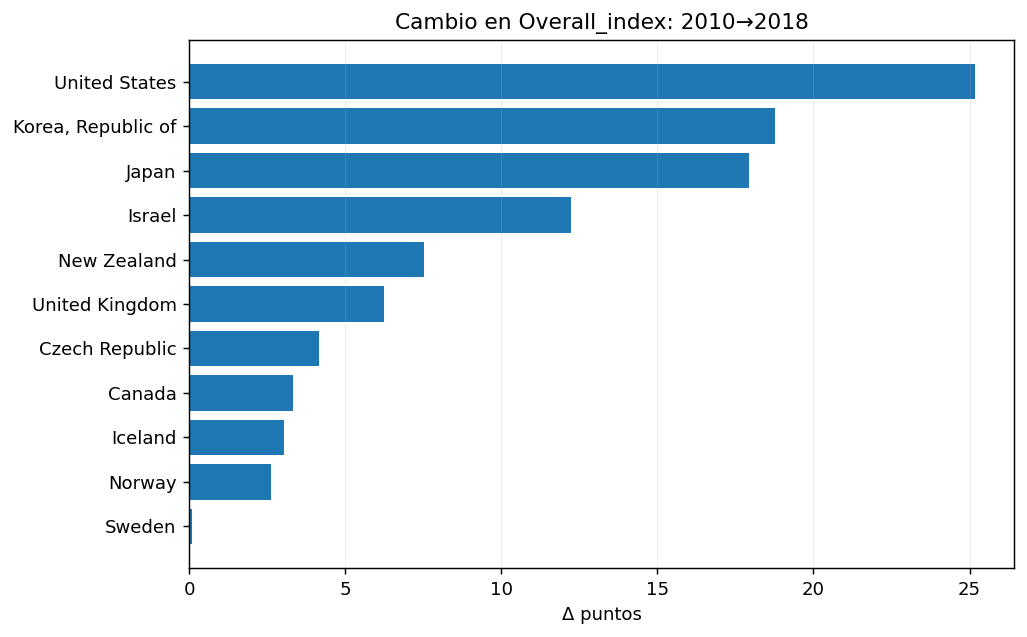

Exportado: mpft_ranking_delta_2010_2018.csv


INDICATOR,COUNTRY,A,B,delta
8,Sweden,98.26,98.35,0.09
7,Norway,102.26,104.88,2.62
2,Iceland,106.67,109.72,3.05
0,Canada,100.41,103.74,3.33
1,Czech Republic,104.09,108.23,4.15
9,United Kingdom,101.45,107.70,6.25
6,New Zealand,103.26,110.77,7.51
3,Israel,122.81,135.05,12.24
4,Japan,96.29,114.22,17.94
5,"Korea, Republic of",102.74,121.52,18.77


In [38]:
# Celda 10
year_a, year_b = 2010, 2018 

A = panel[panel["YEAR"]==year_a][["COUNTRY","Overall_index"]].rename(columns={"Overall_index":"A"})
B = panel[panel["YEAR"]==year_b][["COUNTRY","Overall_index"]].rename(columns={"Overall_index":"B"})
chg = (A.merge(B, on="COUNTRY", how="inner")
         .assign(delta=lambda d: d["B"]-d["A"])
         .sort_values("delta", ascending=True))  # ascendente para barh “de abajo hacia arriba”

plt.figure(figsize=(8, 5))
plt.barh(chg["COUNTRY"], chg["delta"])
plt.title(f"Cambio en Overall_index: {year_a}→{year_b}")
plt.xlabel("Δ puntos"); plt.ylabel("")
plt.grid(axis="x", linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()

# Export ranking
chg.round(2).to_csv(OUT_DIR/f"mpft_ranking_delta_{year_a}_{year_b}.csv", index=False)
print("Exportado:", f"mpft_ranking_delta_{year_a}_{year_b}.csv")
display(chg.round(2))